In [3]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, draw, transform
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import math
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from pprint import pprint

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Hough Transform with point clouds, output is the centers and the related 2d image/edges 

Note: This Hough transform is connected with below mask segmentation, so the number of points before and after projection should be very close, circle radius is also measured in such context.

When J.S wrote the code, the projected image width = range_x * 1000(approximate 740), the radius under this proportion is 27, and she has wrote a detailed filtering based on selected parameters. Suprisingly, this parameter works for the not downsampled as well, perhaps because this overprojection still keeps the geometric relationship around the detected circle, and is therefore robust.

In [4]:

    
# Function to calculate Euclidean distance
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def Hough_Circle_Centers(points):
    
    MIN_DISTANCE = 70  # Minimum distance between circle centers
    MAX_PEAKS = 128    # Maximum number of circles to process per file
    RADIUS_SCALING_FACTOR = 1000  # Scaling for the Hough radius
    
    #project to 2D 
    projected_points = points[:, :2]
    print('the number of 3D projected points are : ', len(projected_points))
    
    #Getting x,y maximum and minimum  
    min_vals = np.min(projected_points, axis=0)
    print("min_vals is : ",min_vals)
    max_vals = np.max(projected_points, axis=0)
    print("max_vals is : ", max_vals)

    range_x = max_vals[0] - min_vals[0]
    range_y = max_vals[1] - min_vals[1]

    #Calculate number of points on X and on Y in 2D projection image
    num_of_points_on_x = range_x*1000#np.ceil(range_x/0.0004)
    num_of_points_on_y = range_y*1000 #np.ceil(range_y/0.0004)
    
    
    print('num_of_points_on_x is : ', num_of_points_on_x)
    print('num_of_points_on_y is : ', num_of_points_on_y)

    #Initialize the 2D image for projection

    image_width = int(num_of_points_on_x) 
    image_height = int(num_of_points_on_y)


    print('image_width is : ', image_width)
    print('image_height is: ', image_height)
    
    image_size = (image_height, image_width)
    image = np.zeros(image_size, dtype=np.uint8)
    
    projected_points_num = 0
    for point in projected_points:
    # Map coordinates to image space (normalize the points to the image size)
        x = int((point[0] - min_vals[0]) / range_x * (image_width - 1))  # Map to x-axis (horizontal)
        y = int((point[1] - min_vals[1]) / range_y * (image_height - 1))  # Map to y-axis (vertical)
        
        projected_points_num = projected_points_num+1
        
        image[y, x] = 255
    
    
        #visualize the edges, if needed
    '''
    # Create a figure for a single plot
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size as needed

    # Plot the binary image
    ax.imshow(edges, cmap='gray', extent=(0, edges.shape[1], edges.shape[0], 0))  # Map pixel dimensions with `extent`
    ax.set_title("Binary Image")  # Title of the plot
    ax.set_xlabel("X Distance (pixels)")  # Label for the x-axis
    ax.set_ylabel("Y Distance (pixels)")  # Label for the y-axis
    ax.axis('on')  # Ensure the axis is visible

    # Add ticks to represent pixel units
    ax.set_xticks(range(0, edges.shape[1] + 1, edges.shape[1] // 10))  # Divide into 10 intervals
    ax.set_yticks(range(0, edges.shape[0] + 1, edges.shape[0] // 10))  # Divide into 10 intervals

    # Display the plot
    plt.tight_layout()
    plt.show()
    '''
  
    # Edge detection
    edges = feature.canny(image, sigma=1.3, low_threshold=185, high_threshold=200)

    # Hough Circle Transform
    hough_radii = np.array([27])  # Adjust radii as needed
    hough_res = transform.hough_circle(edges, 27)

    accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, [27,])


    # Collect detected circles
    circles = sorted(zip(accums, cx, cy, radii), reverse=True, key=lambda x: x[0])

    # Filter circles based on minimum distance and limit the number of detections
    final_centers = []
    final_radii = []
    output_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for acc, center_x, center_y, radius in circles:
        if len(final_centers) >= MAX_PEAKS:
            break  # Stop if the maximum number of circles is reached

        overlap = any(
            distance((center_x, center_y), (fc[0], fc[1])) < MIN_DISTANCE
            for fc in final_centers
        )
        if not overlap:
            final_centers.append((center_x, center_y))
            final_radii.append(radius)
            circy, circx = draw.circle_perimeter(center_y, center_x, radius, shape=image.shape)
            # Ensure the circle coordinates are within bounds of the image
            valid = (circx >= 0) & (circx < output_image.shape[1]) & (circy >= 0) & (circy < output_image.shape[0])
            circx, circy = circx[valid], circy[valid]
            
            # Assign the color (e.g., red) to each pixel on the circle perimeter
            output_image[circy, circx] = [255, 0, 0]

    # Debug: Check detected circles
    #print(f"{filename}: {len(final_centers)} circles detected after filtering.")


    # Sort circles first by x-coordinate, then by y-coordinate for left-to-right, top-to-bottom order
    final_centers_sorted = sorted(zip(final_centers, final_radii), key=lambda x: (x[0][0], x[0][1]))

    
    # Assuming final_centers_sorted is already defined
    # Extract x and y values from the sorted centers
    x_values = np.array([center[0][0] for center in final_centers_sorted]).reshape(-1, 1)
    y_values = np.array([center[0][1] for center in final_centers_sorted])

    # Perform KMeans clustering on x-values to group them into 8 columns
    kmeans = KMeans(n_clusters=8, random_state=0)
    kmeans.fit(x_values)
    x_labels = kmeans.labels_

    # Map each cluster label to its cluster center for sorting
    cluster_centers = kmeans.cluster_centers_.flatten()
    label_to_center = {label: cluster_centers[label] for label in np.unique(x_labels)}

    # Sort cluster labels based on their x-coordinate centers to maintain column order
    sorted_labels = sorted(label_to_center.items(), key=lambda x: x[1])
    label_order = [label for label, center in sorted_labels]

    # Initialize a 16x8 matrix filled with [-1,-1]. So if any of these [0,0] remains, there's a missing circle
    matrix = [[[0,0] for _ in range(8)] for _ in range(16)]  # 16 rows x 8 columns

    # Build the matrix by assigning circles to their respective positions
    for col_idx, label in enumerate(label_order):
        # Get indices of circles belonging to the current cluster (column)
        indices = [i for i, l in enumerate(x_labels) if l == label]
        # Get the corresponding y-values and indices
        y_in_col = [(y_values[i], i) for i in indices]
        # Sort circles in the column by their y-values (from top to bottom)
        y_in_col_sorted = sorted(y_in_col)
        # Assign circles to the matrix rows
        for row_idx, (y, i) in enumerate(y_in_col_sorted):
            if row_idx < 16:
                center = final_centers_sorted[i][0]  # Extract the (x, y) coordinates
                matrix[row_idx][col_idx] = [center[0], center[1]]
            else:
            # If more than 16 circles in a column, ignore the extra ones
                pass

    # Now, 'matrix' is a 16x8 matrix where each element is either [x, y] or [0,0]
    
    
    # Create a figure for a single plot
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
  
    # Display the image with detected circles
    ax.imshow(output_image, cmap='gray')  # Show the output image
    ax.set_title("Detected Circles (Hough Transform)")  # Title for the image
    #ax.axis('off')  # Hide the axes for a cleaner look

    # Display the plot
    plt.tight_layout()
    plt.show()
    

    clean_data = [[[int(value) for value in sublist] for sublist in matrix] for matrix in matrix]

    # Pretty-print the cleaned data
    pprint(clean_data, width=150)
    

    centers = [center for (center, _) in final_centers_sorted]
    radii = [r for (_, r) in final_centers_sorted]


    centers = np.array(centers)
    radii = np.array(radii)

    
    return radii, image, edges, max_vals, min_vals,matrix 


the number of 3D projected points are :  265496
min_vals is :  [-0.36826857 -0.60063255]
max_vals is :  [0.39888522 0.61857675]
num_of_points_on_x is :  767.1537875360495
num_of_points_on_y is :  1219.2092978103667
image_width is :  767
image_height is:  1219


C:\ProgramData\anaconda3\envs\NEWENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


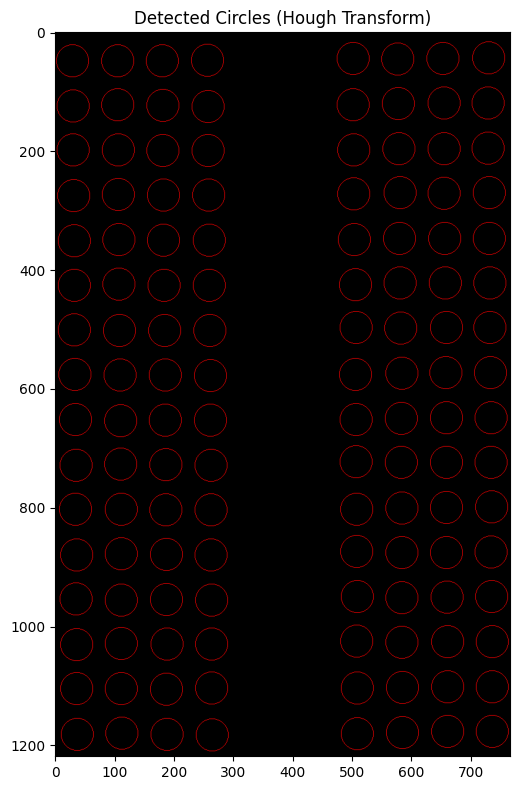

[[[29, 48], [105, 48], [180, 48], [256, 47], [501, 44], [576, 45], [652, 44], [729, 43]],
 [[30, 124], [105, 122], [181, 123], [257, 125], [501, 122], [577, 120], [654, 119], [728, 119]],
 [[30, 198], [106, 198], [181, 199], [257, 199], [502, 198], [578, 196], [654, 196], [728, 195]],
 [[31, 275], [106, 273], [182, 274], [258, 274], [502, 272], [580, 270], [654, 271], [730, 270]],
 [[32, 351], [107, 349], [182, 350], [259, 350], [503, 349], [579, 347], [655, 347], [730, 347]],
 [[32, 426], [107, 424], [183, 426], [259, 426], [505, 425], [580, 422], [656, 422], [731, 422]],
 [[32, 501], [108, 502], [184, 502], [260, 502], [506, 497], [581, 498], [658, 497], [731, 497]],
 [[33, 576], [109, 577], [185, 577], [261, 578], [505, 576], [583, 574], [657, 573], [732, 573]],
 [[34, 652], [110, 654], [185, 653], [261, 653], [506, 652], [582, 650], [658, 649], [733, 649]],
 [[35, 729], [110, 727], [186, 728], [262, 729], [506, 723], [582, 724], [658, 724], [733, 724]],
 [[34, 803], [111, 803], [18

In [5]:
fuzzy_image = r"C:\Users\64453\Desktop\OneDrive_1_2024-10-22\DATA_3F_DOWNSAMPLED10_WITHOUT_EARS_e0_01_SEGMENTED\2024-09-02_130544_243301-11\raw\tray-b-4-b_L2_part_2_downsample_10_without_ears_seg_pipes.ply"
initial_image = '/Users/pmmac/Desktop/OneDrive_1_2024-10-22/DATA_3F_DOWNSAMPLED10_WITHOUT_EARS_e0_01_SEGMENTED/2024-09-02_130544_243301-11/raw/tray-b-4-a_L2_part_1_downsample_10_without_ears_seg_pipes.ply'
current_image = r"C:\Users\64453\Desktop\OneDrive_1_2024-10-22\DATA_3F_DOWNSAMPLED10_WITHOUT_EARS_e0_01_SEGMENTED\2024-09-02_155419_243301-12\raw\tray-b-4-a_L2_part_3_downsample_10_without_ears_seg_pipes.ply"


# pcd = o3d.io.read_point_cloud(current_image)
pcd = o3d.io.read_point_cloud(r"C:\Users\64453\Desktop\OneDrive_1_2024-10-22\DATA_3F_DOWNSAMPLED10_WITHOUT_EARS_e0_01_SEGMENTED\2024-09-02_161540_243301-13\raw\tray-b-4-d_L2_part_4_downsample_10_without_ears_seg_pipes.ply")
# o3d.visualization.draw_geometries([pcd])
points = np.asarray(pcd.points)
radii,image,edges, max_vals, min_vals, matrix = Hough_Circle_Centers(points)

# Align Pivots(utilizing Hough centers to output image center and rotation degree)

In [6]:

def get_ordered_list(points, x, y):
    distances = (points[:, 0] - x)**2 + (points[:, 1] - y)**2
    sorted_indices = np.argsort(distances)
    return points[sorted_indices]

def Align_Pivots_from_Centers(matrix, radii, image, max_vals, min_vals):

    # using the first role's 3rd and 7th center to form a line and caculate the coefficients
    point1 = matrix[0][2]
    point2 = matrix[0][6]
    
    x = [point1[0], point2[0]] 
    y = [point1[1], point2[1]]

    #acquire the slope and bias term for the interpolated line
    coefficients = np.polyfit(x, y, 1)
   
    print('getting the rotation coefficients')

    '''
    #To draw the graph of the line in below code
    
    # Print the findings
    print('a =', coefficients[0])
    print('b =', coefficients[1])

    # Let's compute the values of the line...
    polynomial = np.poly1d(coefficients)
    x_axis = np.linspace(0,500,1)
    y_axis = polynomial(x_axis)

    # ...and plot the points and the line
    plt.plot(x_axis, y_axis)
    plt.plot( x[0], y[0], 'go' )
    plt.plot( x[1], y[1], 'go' )
    plt.grid('on')
    plt.show()
    '''
         
    #getting the rotation degree for the chip
    degree = np.arctan(coefficients[0])
    #print('degree is : ', degree)

    image_width = image.shape[1]
    image_height = image.shape[0]
    #acquire current "averaged" center
    psedo_center = [image_width/2,image_height/2]
    print('psedo center is : ' , psedo_center)

    # using 4 symmetrical centers to calculate the precise center
    pivot_centers = [matrix[7][2], matrix[7][5], matrix[8][2], matrix[8][5]]

    print('pivot_centers are : ', pivot_centers)

    #getting the actual center by averaging the 4 centers
    precise_center = np.mean(pivot_centers, axis=0)
    precise_center = np.ceil(precise_center) # note this might be better with floor, not ceil
    #print('precise center after round up is : ', precise_center)

    #convert to int for indexing
    precise_center = precise_center.astype(int)
    print('precise_center is : ', precise_center)
    #print('image size is : ', image_size)


    #if you want to visualize in the 2D image the actual center(by setting 8 neighbors as 255),
    #unquote below
    '''
    def get_neighbors(point):
        x, y = point
        # Generate all 8 neighbors
        neighbors = [
            (x - 1, y - 1),  # Top-left
            (x, y - 1),      # Top
            (x + 1, y - 1),  # Top-right
            (x - 1, y),      # Left
            (x + 1, y),      # Right
            (x - 1, y + 1),  # Bottom-left
            (x, y + 1),      # Bottom
            (x + 1, y + 1)   # Bottom-right
            ]
        return neighbors

    # Example usage
    point = (420, 652)
    neighbors = get_neighbors(point)

    print('neighbors are : ', neighbors)
    print("neighbors type is : ", type(neighbors))
    '''
 
    
    range_x = max_vals[0] - min_vals[0]
    range_y = max_vals[1] - min_vals[1]
    
    
    # project the 2D center back to 3D 
    precise_x_3d = precise_center[0] / (image_width - 1) * range_x + min_vals[0]
    precise_y_3d = precise_center[1] / (image_height - 1) * range_y + min_vals[1]

    centerin3d = [precise_x_3d,precise_y_3d]

    print('centerin3d is : ', centerin3d)
    print('rotation degree is : ', degree)

   
    return centerin3d, degree

In [7]:
centerin3d, degree = Align_Pivots_from_Centers(matrix, radii, image, max_vals, min_vals)    

getting the rotation coefficients
psedo center is :  [383.5, 609.5]
pivot_centers are :  [[185, 577], [583, 574], [185, 653], [582, 650]]
precise_center is :  [384 614]
centerin3d is :  [0.016309829066597947, 0.013977065307464787]
rotation degree is :  -0.008474373402970605


# Alignment (center align and rotation)

In [8]:
def Alignment(pcd, radii, image, max_vals, min_vals, centerin3d, degree):  

    #inlier_cloud = o3d.io.read_point_cloud('/Users/pmmac/Desktop/OneDrive_1_2024-10-22/DATA_3F_DOWNSAMPLED10_WITHOUT_EARS_e0_01/2024-09-02_130544_243301-11/raw/tray-b-4-a_L2_part_1_downsample_10_without_ears.ply')
    # Create a coordinate frame (axis)
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0., 0., 0.])


    # Visualize the point cloud with the coordinate frame
    o3d.visualization.draw_geometries([pcd,axis], window_name="Point Cloud with Axis")

    rotation_center = np.array([centerin3d[0], centerin3d[1], 0])

    #degree = np.pi / 4*3 #example, 135 degree
    # Define the rotation angle (in radians)
    angle = -degree  

    # Step 1: Translate the point cloud to center the rotation point at the origin
    translation_to_origin = -rotation_center
    pcd.translate(translation_to_origin)

    # Step 2: Create the rotation matrix for rotation around the Z-axis
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,             1]
    ])

    # Apply the rotation matrix
    pcd.rotate(rotation_matrix, center=(0, 0, 0))  # Rotate around the origin

    # Create a coordinate frame (axis)
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])

    # Visualize the aligned point cloud with the coordinate frame
    o3d.visualization.draw_geometries([pcd,axis], window_name="Point Cloud with Axis")
    
    return pcd

# Align pipes, and use acquired pivots to align corresponding chips

the number of 3D projected points are :  266339
min_vals is :  [-0.35464147 -0.60073489]
max_vals is :  [0.40790086 0.61611663]
num_of_points_on_x is :  762.5423296062221
num_of_points_on_y is :  1216.851517633176
image_width is :  762
image_height is:  1216


C:\ProgramData\anaconda3\envs\NEWENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


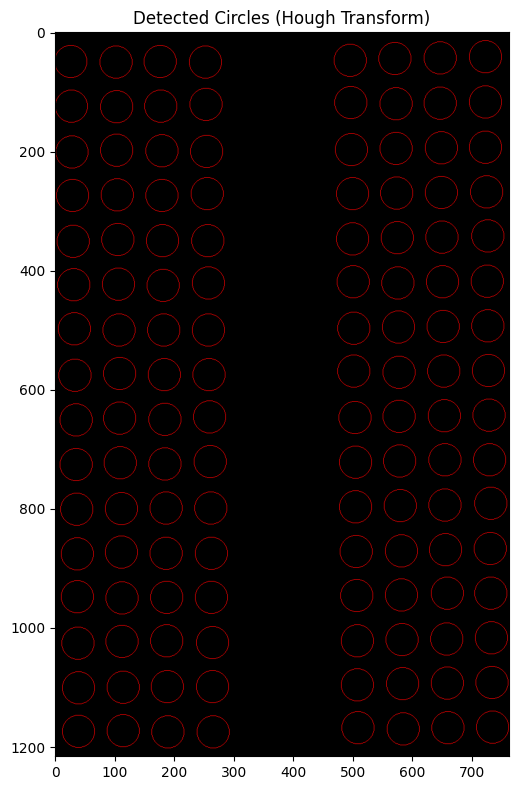

[[[26, 49], [102, 50], [176, 49], [252, 50], [495, 47], [570, 44], [646, 43], [722, 41]],
 [[27, 124], [103, 125], [177, 124], [253, 121], [496, 118], [572, 120], [646, 119], [722, 117]],
 [[28, 201], [103, 198], [179, 199], [254, 200], [497, 197], [572, 195], [648, 194], [722, 193]],
 [[29, 274], [104, 273], [179, 274], [255, 271], [499, 271], [573, 270], [648, 269], [724, 268]],
 [[30, 351], [105, 348], [180, 350], [256, 350], [499, 347], [574, 345], [649, 344], [726, 342]],
 [[31, 424], [106, 423], [181, 425], [257, 421], [500, 419], [575, 421], [650, 419], [725, 418]],
 [[32, 498], [107, 500], [182, 500], [257, 500], [501, 497], [576, 495], [651, 494], [726, 493]],
 [[33, 576], [108, 573], [183, 575], [258, 575], [501, 569], [577, 571], [652, 569], [727, 568]],
 [[35, 651], [108, 648], [184, 650], [259, 646], [503, 647], [577, 645], [653, 644], [728, 643]],
 [[35, 726], [109, 723], [184, 725], [260, 721], [504, 722], [578, 720], [654, 718], [729, 718]],
 [[36, 801], [111, 800], [18

In [14]:
#Reading in Segmented Pipes, acquire the rotation and center point
pcd = o3d.io.read_point_cloud(r"C:\Users\64453\Desktop\OneDrive_1_2024-10-22\DATA_3F_DOWNSAMPLED10_WITHOUT_EARS_e0_01_SEGMENTED\2024-09-02_161540_243301-13\raw\tray-b-4-a_L2_part_2_downsample_10_without_ears_seg_pipes.ply")
points = np.asarray(pcd.points)
radii,image,edges, max_vals, min_vals, matrix = Hough_Circle_Centers(points)
centerin3d, degree = Align_Pivots_from_Centers(matrix, radii, image, max_vals, min_vals)

#Reading in Corresponding chip, align using the pipes' rotation degree and center
pcd2 = o3d.io.read_point_cloud(r"C:\Users\64453\Desktop\OneDrive_1_2024-10-22\DATA_3F_DOWNSAMPLED10\2024-09-02_161540_243301-13\raw\tray-b-4-a_L2_part_2_downsample_10.ply")
pcd2_aligned = Alignment(pcd2, radii, image, max_vals, min_vals, centerin3d, degree)